<a href="https://colab.research.google.com/github/diptisahu/Emoji-Prediction/blob/main/DNN_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Github/

Mounted at /content/drive
/content/drive/MyDrive/Github


In [ ]:
glove_dir = './glove.6B.300d.txt'
input_dim = 300

vocab = {}
with open(glove_dir, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        vocab[word] = vector
f.close()

print('Found %s word vectors.' %len(vocab))

Found 400000 word vectors.


In [ ]:
max_len = 50
zero_padding = [0]*input_dim

def get_embeddings(text, emb="LSTM"):
    if emb == "DNN":
        embedding = [0]*input_dim
        i = 0
        for word in text.split(' '):
            if word in vocab:
                i += 1
                embedding += vocab[word]

        if i != 0:
            embedding /= i

        scale = 0 # noise weight_scale
        noise = np.random.randn(input_dim)*scale
        embedding += noise
    elif emb == "LSTM":
        embedding = []
        i = 0
        for word in text.split(' '):
            if i == max_len:
                break
            if word in vocab:
                i += 1
                embedding.append(vocab[word])
        
        while i < max_len:
            i += 1
            embedding.append(zero_padding)
            
    return embedding

In [ ]:
def clean(text):
    """ Function to clean the text """
    text = text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    
    # Remove numbers from string
    texter = re.sub(pattern=r"[+-]?\d+(?:\.\d+)?", repl="", string=texter, count=0, flags=0)
    texter = texter.replace("  ", " ")
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = re.sub(r'[^\w\s]', '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
def transform(X, emb="LSTM"):
    embeddings = []
    for item in X:
        item = clean(item)
        embedding = get_embeddings(item, emb)
        embeddings.append(embedding)
    
    return embeddings

In [ ]:
inputs_file = "./tweet.text"
labels_file = "./tweet_labels.txt"

X = []
with open(inputs_file, encoding='utf8') as f:
    for line in f:
        X.append(line)
f.close()
# print(len(X))

y = []
with open(labels_file, encoding='utf8') as f:
    for line in f:
        y.append(int(line))
f.close()

In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 1e-4
dropout = 0.3

In [ ]:
X_dnn = transform(X, "DNN")
X_train, X_test, y_train, y_test = train_test_split(X_dnn, y, test_size=0.15, random_state=42)

X_tr = torch.tensor(X_train, dtype=torch.float).to('cuda')
y_tr = torch.tensor(y_train).to('cuda')
train = TensorDataset(X_tr, y_tr)
trainloader = DataLoader(train, batch_size=batch_size)

X_te = torch.tensor(X_test, dtype=torch.float).to('cuda')
y_te = torch.tensor(y_test).to('cuda')
test = TensorDataset(X_te, y_te)
testloader = DataLoader(test)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 500)
        self.hidden1 = nn.Linear(500, 500)
        self.hidden2 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 20)
        self.dropout = nn.Dropout(0.25)
        
        self.batchnorm1 = nn.BatchNorm1d(500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(500)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = F.relu(self.hidden1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
#         x = self.fc2(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

net = Net().to('cuda')

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# Training
net.train()
training_loss = []
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        training_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(trainloader), loss.data))

Epoch [1/10], Step [500/2344], Loss: 2.7250
Epoch [1/10], Step [1000/2344], Loss: 2.4957
Epoch [1/10], Step [1500/2344], Loss: 2.4863
Epoch [1/10], Step [2000/2344], Loss: 2.3954
Epoch [2/10], Step [500/2344], Loss: 2.4862
Epoch [2/10], Step [1000/2344], Loss: 2.3907
Epoch [2/10], Step [1500/2344], Loss: 2.3560
Epoch [2/10], Step [2000/2344], Loss: 2.3420
Epoch [3/10], Step [500/2344], Loss: 2.4469
Epoch [3/10], Step [1000/2344], Loss: 2.3505
Epoch [3/10], Step [1500/2344], Loss: 2.2896
Epoch [3/10], Step [2000/2344], Loss: 2.2777
Epoch [4/10], Step [500/2344], Loss: 2.4041
Epoch [4/10], Step [1000/2344], Loss: 2.3346
Epoch [4/10], Step [1500/2344], Loss: 2.2825
Epoch [4/10], Step [2000/2344], Loss: 2.2231
Epoch [5/10], Step [500/2344], Loss: 2.4053
Epoch [5/10], Step [1000/2344], Loss: 2.3195
Epoch [5/10], Step [1500/2344], Loss: 2.2908
Epoch [5/10], Step [2000/2344], Loss: 2.2691
Epoch [6/10], Step [500/2344], Loss: 2.3677
Epoch [6/10], Step [1000/2344], Loss: 2.2861
Epoch [6/10], St

In [ ]:
# Testing
net.eval()
outputs = net(X_te)

_, predicted = torch.max(outputs, 1)

total = y_te.size(0)
correct = (predicted == y_te).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

Accuracy of the model is: 32.04%


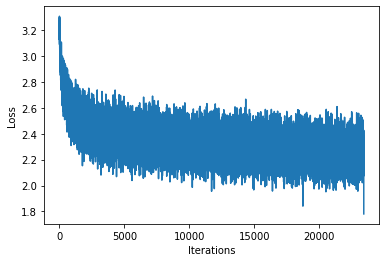

In [ ]:
fig = plt.figure()
plt.plot(training_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()